In [43]:
import sys
import os
import importlib
from collections import defaultdict

import pandas as pd

#!{sys.executable} -m pip install --upgrade seaborn
#%load_ext autotime
#import time

import statistics
import matplotlib.pyplot as plt

import numpy as np
import math

import random

import seaborn as sns

from copy import deepcopy
import warnings


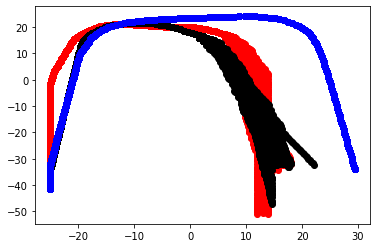

In [49]:
neutral_data = pd.read_csv('save_fixed_model_2/run_position_0.0.log',
                    #sep='\t', 
                    names=["episode","model", "x", "y"])

safe_data = pd.read_csv('save_fixed_model_2/run_position_-1.0.log',
                    #sep='\t', 
                    names=["episode","model", "x", "y"])

risk_data = pd.read_csv('save_fixed_model_2/run_position_1.0.log',
                    #sep='\t', 
                    names=["episode","model", "x", "y"])

plt.plot(risk_data['x'], risk_data['y'], 'o', color='red')
plt.plot(neutral_data['x'], neutral_data['y'], 'o', color='black')
plt.plot(safe_data['x'], safe_data['y'], 'o', color='blue')

plt.show()

In [53]:
def draw_img_state(shape, state_img_width, state=-1, policy=[], color=True, print_img=False):
        h, w = shape

        # adjusting image size to mat plot
        img_width = state_img_width/100

        fig = plt.figure(figsize=(img_width, img_width))
        ax = fig.add_subplot(111, aspect='equal')

        a2uv = {0.0: (0, -1),  # north
                1.0: (0, 1),  # south
                2.0: (1, 0),  # east
                3.0: (-1, 0)  # west
                }

        for y in range(h):
            for x in range(w):
                s = x + (y * w)

                # By default, the (0, 0) coordinate in matplotlib is the bottom left corner,
                # so we need to invert the y coordinate to plot the matrix correctly
                matplot_x = x
                matplot_y = h - y - 1

                if x == 0:  # margem direita grama
                    if color:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='#008200'))
                    else:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, fill=False, hatch='xx'))
                    text = 'D'
                elif x == w - 1:  # margem esquerda grama
                    if color:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='#008200'))
                    else:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, fill=False, hatch='xx'))
                    text = 'E'
                elif y == 0:  # ponte grama
                    text = 'B'
                    if color:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='#008200'))
                    else:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, fill=False, hatch='xx'))
                elif x == w - 2 and y == h - 1:  # meta
                    if color:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='#E66666'))
                    else:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='#727073'))
                elif x == 0 or x == 1:  # margem direita
                    if color:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='#666666'))
                    text = 'D'
                elif x == w - 1  or x == w - 2:  # margem esquerda
                    if color:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='#666666'))
                    text = 'E'
                elif y == 0 or y == 1:  # ponte
                    text = 'B'
                    if color:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='#666666'))
                elif y == h - 1:  # cachoeira
                    hatch = 'xxxxxx'
                    if img_width >= 5:
                        hatch='xx'

                    if color:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='#6666E6'))
                    else:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, fill=False, hatch=hatch))
                else:  # rio
                    hatch = '......'
                    if img_width >= 5:
                        hatch = '..'
                    if color:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='#6666E6'))
                    else:
                        ax.add_patch(plt.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, fill=False, hatch=hatch))

                # policy was given, must draw arrows
                if len(policy) > 0:
                    action = policy[s]
                    if action >= 0:
                        u, v = a2uv[action]
                        ax.arrow(matplot_x - (u * .4), matplot_y + (v * .4), u * .4, -v * .4, color='red', head_width=0.4, head_length=0.4)
                elif s == state:
                    ax.add_patch(plt.Circle((matplot_x, matplot_y), 0.4, facecolor='black'))

                # ax.annotate(str(s), xy=(matplot_x, matplot_y), ha='center', va='center')
        #neutral_data = pd.read_csv('save_fixed_model/run_position_0.0.log',names=["model", "x", "y"])

        #safe_data = pd.read_csv('save_fixed_model/run_position_-1.0_sample.log',names=["model", "x", "y"])

        for index, row in risk_data.iterrows():
            dotx, doty = row['x'], row['y']
            #dotx = -25.000000
            #doty = -41.622845
            norm_x = (dotx/17.5)+2.5
            norm_y = (doty/15)+2.5

            ax.add_patch(plt.Circle((norm_x, norm_y), 0.05, facecolor='red')) 
        
        for index, row in neutral_data.iterrows():
            dotx, doty = row['x'], row['y']
            #dotx = -25.000000
            #doty = -41.622845
            norm_x = (dotx/17.5)+2.5
            norm_y = (doty/15)+2.5

            ax.add_patch(plt.Circle((norm_x, norm_y), 0.05, facecolor='black')) 
            
        for index, row in safe_data.iterrows():
            dotx, doty = row['x'], row['y']
            #dotx = -25.000000
            #doty = -41.622845
            norm_x = (dotx/17.5)+2.5
            norm_y = (doty/15)+2.5

            ax.add_patch(plt.Circle((norm_x, norm_y), 0.05, facecolor='blue')) 
            
        

        offset = .5
        ax.set_xlim(-offset, w - offset)
        ax.set_ylim(-offset, h - offset)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        #ax.hlines(y=np.arange(h + 1) - offset, xmin=-offset, xmax=w - offset, color='black')
        #ax.vlines(x=np.arange(w + 1) - offset, ymin=-offset, ymax=h - offset, color='black')

        plt.savefig('save_fixed_model_2/result.png')
        #plt.show()
        plt.close()

draw_img_state((6,6), 1000)


In [54]:
neutral_data_r = pd.read_csv('save_fixed_model_2/run_reward_0.0.log',
                    #sep='\t', 
                    names=["episode","model", "r"])

safe_data_r = pd.read_csv('save_fixed_model_2/run_reward_-1.0.log',
                    #sep='\t', 
                    names=["episode","model", "r"])

risk_data_r = pd.read_csv('save_fixed_model_2/run_reward_1.0.log',
                    #sep='\t', 
                    names=["episode","model", "r"])

neutral_data_r

,episode,model,r
0,0,save_fixed_model/trial_0.0_0.99_15000.h5,-20.3
1,1,save_fixed_model/trial_0.0_0.99_15000.h5,-22.2
2,2,save_fixed_model/trial_0.0_0.99_15000.h5,-19.7
3,3,save_fixed_model/trial_0.0_0.99_15000.h5,-20.1
4,4,save_fixed_model/trial_0.0_0.99_15000.h5,-22.1
5,5,save_fixed_model/trial_0.0_0.99_15000.h5,-19.9
6,6,save_fixed_model/trial_0.0_0.99_15000.h5,-19.8
7,7,save_fixed_model/trial_0.0_0.99_15000.h5,-22.0
8,8,save_fixed_model/trial_0.0_0.99_15000.h5,-19.9
9,9,save_fixed_model/trial_0.0_0.99_15000.h5,-19.9


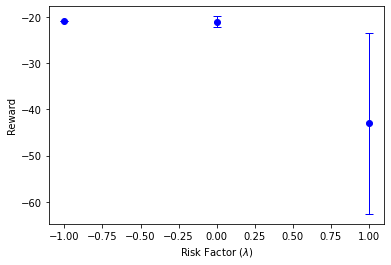

In [71]:
# Value Iteration
df = safe_data_r.mean()
sd = safe_data_r.std()
x = -1
plt.errorbar(x, df['r'], sd['r'], linestyle='None', marker='o', capsize=4, elinewidth=1.0, color='blue')

df = neutral_data_r.mean()
sd = neutral_data_r.std()
x = 0
plt.errorbar(x, df['r'], sd['r'], linestyle='None', marker='o', capsize=4, elinewidth=1.0, color='blue')

df = risk_data_r.mean()
sd = risk_data_r.std()
x = 1
plt.errorbar(x, df['r'], sd['r'], linestyle='None', marker='o', capsize=4, elinewidth=1.0, color='blue')
    
    
#plt.title('Safe Steps by Risk Factor - Value Iteration')
plt.xlabel(r"Risk Factor ($\lambda$)")
plt.ylabel('Reward')

#plt.legend()
plt.savefig('save_fixed_model_2/result_reward.png')
plt.show()

In [65]:
neutral_data_r.mean()['r']

-21.019999999999992